# Lesson 07 - Convolutional Neural Networks

In this lesson, we will learn about convolutional neural networks (CNNs). In particular, we will focus on so-called 1D CNNs that are used for time series analysis or natural language processing (NLP).

In [1]:
import pandas as pd
import numpy as np

from collections import Counter
import itertools

import json


import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, RobustScaler
from sklearn.utils import class_weight

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import TimeDistributed, GlobalAveragePooling1D, GlobalMaxPooling1D, Activation, Input, LSTM, GRU, Dense, Dropout, Flatten, Embedding, SpatialDropout1D, Bidirectional, CuDNNGRU
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, concatenate
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, activations
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow import set_random_seed
from keras import backend as K

# This part required only for GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
sess = tf.Session(config=config)
K.set_session(sess)


seed = 10293239

C:\Users\user\Anaconda3\envs\ml\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() * 0.8
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Load data and basic info

Let's load the same dataset as in Lesson 01.

In [3]:
bugs = pd.read_csv('./data/bugs_train.csv', parse_dates=['Opened', 'Changed'], index_col=None)

In [4]:
bugs.head(4)

,Component,Assignee,Status,Summary,Opened,Changed,Priority,Severity,Resolution
0,Debug,eclipse,VERIFIED,Icons needed for actions (1GI5UXW),2001-10-10 22:14:41,2001-10-18 11:51:14,P1,enhancement,FIXED
1,Debug,darin.eclipse,RESOLVED,README: Hit count not reset (1GET20Y),2001-10-10 22:14:42,2001-11-28 13:42:46,P3,normal,WORKSFORME
2,Debug,darin.eclipse,CLOSED,Use styled text in console (1G9S1YF),2001-10-10 22:14:43,2002-06-26 11:32:05,P3,normal,WONTFIX
3,Debug,eclipse,VERIFIED,StringBuffer representation (1GE3BFA),2001-10-10 22:14:44,2014-12-02 06:37:26,P3,normal,FIXED


## The classification task (the problem to solve)

Our task remains the same for this lesson - we would be to predict what will be the resolution of the defect report (y) based on the description of a defect (X). 

## Data preparation (features)

Let's quickly replicate processing of the Component and Severity features, as well as converting the decision class.

In [5]:
# we will make a copy of the main data
bugs_small = bugs[["Assignee", "Component", "Severity", "Status", "Priority", "Opened", "Changed", "Summary", "Resolution"]]

# Component
bugs_small = pd.get_dummies(bugs_small, columns=['Component'], prefix="Component")

# Severity
bugs_small['Severity'] = bugs_small['Severity'].map(
    {'enhancement':0, 'trivial':1, 'minor':2, 'normal':3, 'major':4, 'critical':5, 'blocker':6})

# Status
bugs_small['Status'] = bugs_small['Status'].map(
    {'VERIFIED':0, 'RESOLVED':1, 'CLOSED':2})

# Priority
bugs_small['Priority'] = bugs_small['Priority'].map(
    {'P1':1, 'P2':2, 'P3':3, 'P4':4, 'P5':5})


y = bugs_small['Resolution']
X = bugs_small.drop(['Resolution'], axis=1, inplace=False)


# Days
X['Days'] = X.apply(lambda x: (x.Changed - x.Opened).days, axis=1)
X.drop(["Changed", "Opened"], inplace=True, axis=1)

# Assignee
inbox = [1 if x.endswith('-inbox') else 0 for x in bugs_small['Assignee']]
X.insert(loc=0, column='Assignee_Inbox', value=pd.Series(inbox))
    
eclipse = [1 if x.endswith('eclipse') else 0 for x in bugs_small['Assignee']]
X.insert(loc=0, column='Assignee_Eclipse', value=pd.Series(eclipse))
X.drop(["Assignee"], inplace=True, axis=1)




In [6]:
X.head(4)

,Assignee_Eclipse,Assignee_Inbox,Severity,Status,Priority,Summary,Component_APT,Component_Core,Component_Debug,Component_Doc,Component_Text,Component_UI,Days
0,1,0,0,0,1,Icons needed for actions (1GI5UXW),0,0,1,0,0,0,7
1,1,0,3,1,3,README: Hit count not reset (1GET20Y),0,0,1,0,0,0,48
2,1,0,3,2,3,Use styled text in console (1G9S1YF),0,0,1,0,0,0,258
3,1,0,3,0,3,StringBuffer representation (1GE3BFA),0,0,1,0,0,0,4800


In [7]:
y_binary = np.array([1 if x == "FIXED" else 0 for x in y])
y_binary

array([1, 0, 0, ..., 0, 0, 0])

Let's split the dataset into training and testing sets

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.33, random_state=seed, stratify=y_binary)

## Prepare text input from defect-report summaries

We have to convert the text in the summary column into a sequence of numbers. Each number will correspond to the index of the word it represent.


In [9]:
train_summaries = [str(x) for x in X_train['Summary'].tolist()]
test_summaries = [str(x) for x in X_test['Summary'].tolist()]

In [10]:
train_summaries[:2]

['Code Formatter exchange several blank lines  w/ one',
 'TVT3.0:  HTML files missing DOCTYPE tag']

### Tokenizing the text

In the first step, we have to tokenize the text. You can use tokenizers from the NLP libraries like NLTK or Spicy. However, to simpify we will use here a basic tokenizer offered by Keras.

In [11]:
tokenized_train_summaries = [text_to_word_sequence(x, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                                                   lower=True, split=' ') for x in train_summaries]
tokenized_test_summaries = [text_to_word_sequence(x, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                                                   lower=True, split=' ') for x in test_summaries]

In [12]:
tokenized_train_summaries[0]

['code', 'formatter', 'exchange', 'several', 'blank', 'lines', 'w', 'one']

### Building a vocabulary

In [13]:
# we have to flatten the tokenized_train_summaries to a single list to build the vocabulary
tokenized_train_summaries_flat = list(itertools.chain(*tokenized_train_summaries))

counter = Counter(tokenized_train_summaries_flat)

# how many most common words will we take?
NUM_WORDS = 6000

# we construct a vocabulary
if NUM_WORDS is not None:
    vocab = [x for x,y in counter.most_common(NUM_WORDS)]
else:
    vocab = counter.keys()
    

### Convert each text to a sequence of word indices:

In [14]:
# we reserve 0 - padding and 1 a token that is not in the vocabulary
# if the embedding is frozen it would be enough to have only zero preserved for padding 
def tokens2index(tokens, vocab):
    result = []
    for token in tokens:
        if token in vocab:
            result.append(vocab.index(token)+2)
        else:
            result.append(1) ## OOV
    return result

In [15]:
tokens2index(tokenized_train_summaries[0], vocab)

[15, 47, 3107, 1069, 640, 282, 923, 245]

### Pad sequences so they have equal length

We need to make all the sequences of equal length. Let's see what is the distribution of sequence lengths and choose the length that will be sufficient for most of the cases. Of course, the shorter the length the less parameters of the model, so we have to choose wisely to balance between the model complexity and ability to cover the caes in our dataset.

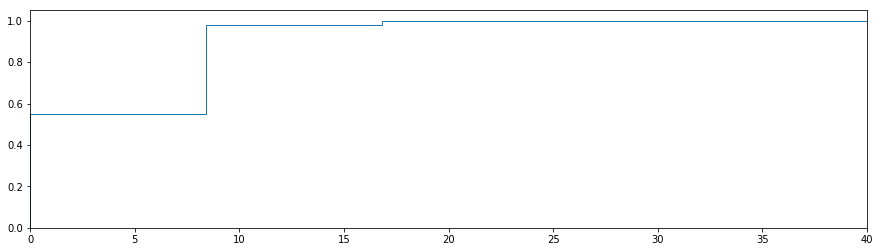

The value for 90% is 13.0, 98% is 16.0, 99% is 18.0, and 100% is 42.0


In [16]:
lengths = [len(x) for x in tokenized_train_summaries]

fig, ax = plt.subplots(figsize=(15, 4))

# plot the cumulative histogram
n_bins = 5
n, bins, patches = ax.hist(lengths, n_bins, density=True, histtype='step',
                           cumulative=True, label='Empirical')

plt.xlim((0,40))
plt.show()
print("The value for 90% is {}, 98% is {}, 99% is {}, and 100% is {}".format(*np.percentile(lengths, [90, 98, 99, 100])))

We can see that  if we choose 16 it should cover 99% of cases. 

In [17]:
MAX_SEQUENCE_LENGTH = 16

In [18]:
def texts2index_padded(texts, vocab, seq_length):
    texts_ids = [tokens2index(tokens, vocab) for tokens in texts]
    return pad_sequences(texts_ids, maxlen=seq_length, 
                          dtype='int32', padding='post', truncating='post', value=0.0)

In [19]:
padded_train_summaries_ids = texts2index_padded(tokenized_train_summaries, vocab, seq_length=MAX_SEQUENCE_LENGTH)
padded_test_summaries_ids = texts2index_padded(tokenized_test_summaries, vocab, seq_length=MAX_SEQUENCE_LENGTH)

In [20]:
padded_train_summaries_ids[:2]

array([[  15,   47, 3107, 1069,  640,  282,  923,  245,    0,    0,    0,
           0,    0,    0,    0,    0],
       [1230,  118,  599,   94,   59, 4327,  293,    0,    0,    0,    0,
           0,    0,    0,    0,    0]])

## Understanding the layers

We will now go through different type of layers before we will build a model.

### Embedding layer

We have transformed text to vectors of numbers. That's great. But could we use it train a model? Well, no. Indices of words would be treated as numbers, i.e., treated as a ratio variable. This is meaningless.

Therefore, we need a vector representation of each word that consists of "true" numbers. We create a layer that will work as a mapping between a word indices and such vectors. Then, these vectors can be determined during the process of training the network or trained separately and "imported" to the model (we call it transfer learning).

In [21]:
# This will be an input to our network - for each defect - a list of word indices
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="input")

Our embedding matrix have two dimensions. The input dimension will be the number of words in our vocabulary and the output variable will be the length of embedding vector. The output of the layer will be of size sequence length x embedding vector length.

In [22]:
INPUT_DIM = len(vocab)
OUTPUT_DIM = 10

In [23]:
embedding_layer = Embedding(input_dim=INPUT_DIM,
                 output_dim=OUTPUT_DIM,
                 mask_zero=False,
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)
embedded_sequences = embedding_layer(text_input)

In [24]:
model = Model([text_input] , embedded_sequences) 

optimizer = Adam(lr=0.001, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 16, 10)            60000     
Total params: 60,000
Trainable params: 60,000
Non-trainable params: 0
_________________________________________________________________


Let's take the first summary

In [26]:
train_summaries[0]

'Code Formatter exchange several blank lines  w/ one'

When we embed it (we have to reshape it so it is a two dimensional array 1x16), we obtain what we expected. Of course, our current word embeddings is random.

In [27]:
model.predict(padded_train_summaries_ids[0].reshape(1,-1)).shape

(1, 16, 10)

In [28]:
model.predict(padded_train_summaries_ids[0].reshape(1,-1))

array([[[ 0.03841952, -0.00128288, -0.03919214,  0.03979334,
          0.04737847,  0.04214337,  0.00811468,  0.03492378,
          0.03149137,  0.03812524],
        [-0.01242846,  0.01209965,  0.04128165,  0.02369097,
          0.01772586,  0.04846778,  0.0133849 , -0.03904023,
         -0.02213336,  0.03322763],
        [ 0.03121069, -0.00166617,  0.0264242 , -0.03519494,
          0.03194935,  0.01872606,  0.0329368 , -0.01756637,
          0.02249714,  0.01990855],
        [-0.02714703,  0.02641514,  0.03698857,  0.03335297,
         -0.01993429, -0.04864558,  0.00081931, -0.01338198,
          0.03055773, -0.02230312],
        [ 0.00951511,  0.03685622,  0.0200111 ,  0.03992688,
         -0.03834791, -0.03242838, -0.02334448,  0.04851443,
          0.01146143,  0.02392732],
        [ 0.01439441,  0.00146855, -0.01043812,  0.02573225,
         -0.03110491,  0.02358406,  0.0017427 ,  0.04552073,
         -0.02222648,  0.0140429 ],
        [-0.00382056,  0.00107156, -0.00688099, -0.0

### Convolutional Layer

This is a heart of any convolutional neural network. Here, we will use a layer called Conv1D. The 1D could be confusing because in fact it is accepts two-dimensional inputs (see our embedding dimension -> 16x10). However, the second dimension is not really a dimension in that sense (it is called depth or number of channels). It is maybe easier to understand for the Conv2D layer which accepts three-dimensional input. This one is usually used for image processing. An image has width and lenght - these are its dimensions, and number of channels - yes, this is the magical third dimension that is treated differently. 

Let's simpify our input for a while and assume it has dimension of 4x3 (it will be more compact). So, we have a sequence of 4 elements and each is represented by a vector of 3 numbers.

Convolutional layer trains so-called filters. Each filter "convolves" (moves) through the input and the output is produced by multiplying the corresponding values and weights of the filter, summing them and adding bias (and then passed to the activation function).


Convolutional layer has multiple parameters but the most important are:
* filters - how many filters to train
* kernel_size - what will be the "scanning" area of each filter
* stride - how much the filter moves 

A nice visualization of how convolution works could be found here - http://machinelearninguru.com/computer_vision/basics/convolution/convolution_layer.html.


In [29]:
conv_input = Input(shape=(4, 3), dtype='float32', name="input")

output = Conv1D(filters=2, kernel_size=2,  strides=1,
                kernel_initializer='ones',
                bias_initializer='ones')(conv_input)

model = Model([conv_input] , output) 

optimizer = Adam(lr=0.001, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4, 3)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 2)              14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


We have created a single convolutional layer, which consists of two filters. Each filter has receptive fields of two elements and stride of one element. We also initialize all the filters and bias with 1 so we can see what happens. 

Our layer has 14 parameters. Can you tell why?

Our layer's output has the dimension of 3x2. Can you tell why?

You have your guess but let's see how that works.

Let's prepare the input. Look at it carefully.

In [31]:
x = np.array([[[1,1,3], 
               [2,1,1], 
               [3,1,1],
               [3,1,1]]])
x.shape

(1, 4, 3)

In [32]:
model.predict(x)

array([[[10., 10.],
        [10., 10.],
        [11., 11.]]], dtype=float32)

OK, we see that it is really like this. But, let's think how it happens. 

Let's start from the number of parameters. Each filter has a receptive field of 2 elements and each element is represented by a vector of 3 numbers. So each filter has the size of 3x2. This gives us 12 parameters + bias for each of the filters. So, this results in 14 parameters.

Let's now see how the first row of the output is produced => [10, 10].

[[1,1,3], [2,1,1]] dot product [[1,1],[1,1],[1,1]] -> sum it "channel-wise".


In [33]:
res = np.dot(np.array([[1,1,3], [2,1,1]]), np.array([[1,1],[1,1],[1,1]]))
res

array([[5, 5],
       [4, 4]])

In [34]:
np.sum(res, axis=0) + np.array([1,1]) #bias

array([10, 10])

So, we can see that the output from both filters for this "patch" is the same and equal to 10.

Now you should be able to tell how the remaining two rows of the output are created (btw. we call the output - feature map).

In [35]:
res = np.dot(np.array([[2,1,1], [3,1,1]]), np.array([[1,1],[1,1],[1,1]]))
res = np.sum(res, axis=0) + np.array([1,1]) #bias
res

array([10, 10])

In [36]:
res = np.dot(np.array([[3,1,1], [3,1,1]]), np.array([[1,1],[1,1],[1,1]]))
res = np.sum(res, axis=0) + np.array([1,1]) #bias
res

array([11, 11])

Sometimes the receptive field of a filter is larger than the "patch" to analyze. It such a case we have different strategies to handle missing data, e.g., we pad them with zeros, or use the same values as on the border, etc.

### Pooling

Pooling is a technique of reducing dimensionality of the feature maps bo taking maximum, minimum, or average of certain patch. The hyperparameter pool_size defines the size of the patch. By default stride = pool_size.

In [37]:
conv_input = Input(shape=(4, 3), dtype='float32', name="input")

output = MaxPooling1D(pool_size=2)(conv_input)

model = Model([conv_input] , output) 

optimizer = Adam(lr=0.001, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4, 3)              0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 3)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [39]:
x = np.array([[[1,1,3], 
               [2,1,1], 
               [3,1,1],
               [3,1,1]]])
x.shape

(1, 4, 3)

In [40]:
model.predict(x)

array([[[2., 1., 3.],
        [3., 1., 1.]]], dtype=float32)

Since the pool_size is equal to 2 and stride 2, we have two pairs to compare - rows 1,2 and 3,4. The first output is created as a max of row 1 and 2 row-wise.

In [41]:
np.max(np.array([[1,1,3], [2,1,1]]), axis=0)

array([2, 1, 3])

### Global Pooling 

Works similar as pooling, but operates on different axis.

In [42]:
conv_input = Input(shape=(4, 3), dtype='float32', name="input")

output = GlobalMaxPooling1D()(conv_input)

model = Model([conv_input] , output) 

optimizer = Adam(lr=0.001, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4, 3)              0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 3)                 0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [44]:
x = np.array([[[1,1,3], 
               [2,1,1], 
               [3,1,1],
               [3,1,1]]])
x.shape

(1, 4, 3)

In [45]:
model.predict(x)

array([[3., 1., 3.]], dtype=float32)

## Let's build a model using summary texts only

In [46]:
def create_embedding_matrix(vocab, vector_dim):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size+2, vector_dim))
    for i in range(vocab_size+2):
        if i == 1:
            embedding_matrix[i] = np.zeros(vector_dim)
        elif i > 1:
            embedding_matrix[i] = np.random.random(vector_dim)
    return embedding_matrix

def get_model_global_pool(seq_len=None, vocab=None, embed_size=None):
    
    global seed
    np.random.seed(seed)
    set_random_seed(seed)
    
    vocab_size = len(vocab)+2
    
    text_input = Input(shape=(seq_len,), dtype='int32', name="input")
    
    embedding_matrix = create_embedding_matrix(vocab, embed_size)
    
    embedding_layer = Embedding(input_dim=vocab_size,
                 output_dim=embed_size,
                 weights=[embedding_matrix],
                 mask_zero=False,
                 input_length=seq_len,
                 trainable=True)
    embedded_sequences = embedding_layer(text_input)
    cnn = Dropout(0.1)(embedded_sequences)
    cnn = Conv1D(filters=16, kernel_size=2, strides=1, 
                        padding='same', activation='relu')(embedded_sequences)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Conv1D(filters=16, kernel_size=2, strides=1, 
                        padding='same', activation='relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Dropout(0.3)(cnn)
    cnn = GlobalMaxPooling1D()(cnn)

    output = Dense(1, activation="sigmoid")(cnn)
    
    model = Model([text_input] , output)
    algorithm = Adam(lr=0.005, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=['accuracy'])

    return model

def get_model_dense(seq_len=None, vocab=None, embed_size=None):
    
    global seed
    np.random.seed(seed)
    set_random_seed(seed)
    
    vocab_size = len(vocab)+2
    
    text_input = Input(shape=(seq_len,), dtype='int32', name="input")
    
    embedding_matrix = create_embedding_matrix(vocab, embed_size)
    
    embedding_layer = Embedding(input_dim=vocab_size,
                 output_dim=embed_size,
                 weights=[embedding_matrix],
                 mask_zero=False,
                 input_length=seq_len,
                 trainable=True)
    embedded_sequences = embedding_layer(text_input)
    cnn = Dropout(0.1)(embedded_sequences)
    cnn = Conv1D(filters=16, kernel_size=2, strides=1, 
                        padding='same', activation='relu')(embedded_sequences)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Conv1D(filters=16, kernel_size=2, strides=1, 
                        padding='same', activation='relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)
    cnn = Dense(10, activation="relu")(cnn)
    cnn = Dropout(0.2)(cnn)
    
    output = Dense(1, activation="sigmoid")(cnn)
    
    model = Model([text_input] , output)
    algorithm = Adam(lr=0.005, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [47]:
get_model_global_pool(seq_len=MAX_SEQUENCE_LENGTH, vocab=vocab, embed_size=5).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 16, 5)             30010     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 16)            176       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 16)             528       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 16)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 16)             0         
__________

In [48]:
get_model_dense(seq_len=MAX_SEQUENCE_LENGTH, vocab=vocab, embed_size=5).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 16, 5)             30010     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 16, 16)            176       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 16)             528       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
__________

In [49]:
np.random.seed(seed)
set_random_seed(seed)

callbacks_list = [
    ReduceLROnPlateau( 
        monitor='loss',
        min_lr=0.001, 
        factor=0.5,
        verbose=1,
        patience=10) 
]

pipeline = []
pipeline.append(('classifier', KerasClassifier(build_fn=get_model_dense,  
                                        epochs=50,
                                        batch_size=128, 
                                        verbose=2, 
                                        callbacks=callbacks_list,
                                        seq_len=MAX_SEQUENCE_LENGTH, 
                                        vocab=vocab, 
                                        embed_size=5))) 

model = Pipeline(pipeline)

In [50]:
model.fit(padded_train_summaries_ids, y_train)

Epoch 1/50
 - 3s - loss: 0.6931 - acc: 0.5064
Epoch 2/50
 - 2s - loss: 0.6771 - acc: 0.5719
Epoch 3/50
 - 2s - loss: 0.6370 - acc: 0.6436
Epoch 4/50
 - 2s - loss: 0.6056 - acc: 0.6767
Epoch 5/50
 - 2s - loss: 0.5761 - acc: 0.7029
Epoch 6/50
 - 2s - loss: 0.5483 - acc: 0.7260
Epoch 7/50
 - 2s - loss: 0.5196 - acc: 0.7443
Epoch 8/50
 - 2s - loss: 0.4986 - acc: 0.7602
Epoch 9/50
 - 2s - loss: 0.4705 - acc: 0.7733
Epoch 10/50
 - 2s - loss: 0.4467 - acc: 0.7881
Epoch 11/50
 - 2s - loss: 0.4281 - acc: 0.7975
Epoch 12/50
 - 2s - loss: 0.4085 - acc: 0.8064
Epoch 13/50
 - 2s - loss: 0.3882 - acc: 0.8169
Epoch 14/50
 - 2s - loss: 0.3734 - acc: 0.8204
Epoch 15/50
 - 2s - loss: 0.3597 - acc: 0.8278
Epoch 16/50
 - 2s - loss: 0.3535 - acc: 0.8311
Epoch 17/50
 - 2s - loss: 0.3308 - acc: 0.8429
Epoch 18/50
 - 2s - loss: 0.3233 - acc: 0.8452
Epoch 19/50
 - 2s - loss: 0.3159 - acc: 0.8488
Epoch 20/50
 - 2s - loss: 0.3049 - acc: 0.8542
Epoch 21/50
 - 2s - loss: 0.2957 - acc: 0.8593
Epoch 22/50
 - 2s - lo

Pipeline(memory=None,
     steps=[('classifier', <keras.wrappers.scikit_learn.KerasClassifier object at 0x0000021356F98D68>)])

In [51]:
y_pred = model.predict(padded_test_summaries_ids)

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

"Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(acc, prec, rec, f1)

'Accuracy = 0.569, Precision = 0.570, Recall = 0.569, F1-score = 0.567'

In [53]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix


array([[3675, 3602],
       [2677, 4614]], dtype=int64)

## Pre-trained word embeddings

In the previous model, the word embeddings were trained during the task. However, there exist pre-trained word embeddings that try to capture relationship between the words (see GloVe or Word2Vec for more information). Here we will try to use one of such emmbeddings.

We will use a GloVe model trained on Wikipedia+Gigaworld and, in particular, the version embedding words into 50d vectors. The original file is nearly 170MB, so we will use only it extract containing words appearing in our training set.

In [54]:
with open('glove.6B.50d.json', 'r') as fp:
    embeddings_idx = json.load(fp)

In [58]:
vocab = list(embeddings_idx.keys())
vocab[:3]

['the', 'of', 'to']

If you want to extract such a smaller embedding yourself, you could use the code below (don't run it, it won't work).

In [ ]:
# we have to flatten the tokenized_train_summaries to a single list to build the vocabulary
tokenized_train_summaries_flat = list(itertools.chain(*tokenized_train_summaries))

counter = Counter(tokenized_train_summaries_flat)
vocab = counter.keys()
    
embeddings_index = {}
with open("Path to GloVe\\glove.6B.50d.txt", encoding="utf8") as f:
    for i, line in enumerate(f):
        values = line.split()
        word = values[0]
        if i % 10000:
            print(word)
        if word in vocab:
            try:
                coefs = np.asarray(values[1:], dtype='float32')
            except:
                pass
            embeddings_index[word] = coefs
            
embeddings_index_save = {}
for k,v in embeddings_index.items():
    embeddings_index_save[k] = v.tolist()
    
with open('glove.6B.50d.json', 'w') as fp:
    json.dump(embeddings_index_save, fp)

We have to now encode our summary texts using indices from the new vocabulary.

In [59]:
padded_train_summaries_ids = texts2index_padded(tokenized_train_summaries, vocab, seq_length=MAX_SEQUENCE_LENGTH)
padded_test_summaries_ids = texts2index_padded(tokenized_test_summaries, vocab, seq_length=MAX_SEQUENCE_LENGTH)

In [60]:
def create_embedding_matrix_pretrained(vocab, embeddings_idx, vector_dim):
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size+2, vector_dim))
    for i in range(vocab_size+2):
        if i == 1:
            embedding_matrix[i] = np.zeros(vector_dim)
        elif i > 1:
            embedding_matrix[i] = embeddings_idx[vocab[i-2]]
    return embedding_matrix

def get_model_global_pool(seq_len=None, vocab=None, embeddings_idx=None, embed_size=50):
    
    global seed
    np.random.seed(seed)
    set_random_seed(seed)
    
    vocab_size = len(vocab)+2
    
    text_input = Input(shape=(seq_len,), dtype='int32', name="input")
    
    embedding_matrix = create_embedding_matrix_pretrained(vocab, embeddings_idx, embed_size)
    
    embedding_layer = Embedding(input_dim=vocab_size,
                 output_dim=embed_size,
                 weights=[embedding_matrix],
                 mask_zero=False,
                 input_length=seq_len,
                 trainable=False)
    embedded_sequences = embedding_layer(text_input)

    cnn = Conv1D(filters=16, kernel_size=2, strides=1, 
                        padding='same', activation='relu')(embedded_sequences)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Conv1D(filters=16, kernel_size=2, strides=1, 
                        padding='same', activation='relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Dropout(0.2)(cnn)
    cnn = GlobalMaxPooling1D()(cnn)

    output = Dense(1, activation="sigmoid")(cnn)
    
    model = Model([text_input] , output)
    algorithm = Adam(lr=0.005, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=['accuracy'])

    return model

def get_model_dense(seq_len=None, vocab=None, embeddings_idx=None, embed_size=50):
    
    global seed
    np.random.seed(seed)
    set_random_seed(seed)
    
    vocab_size = len(vocab)+2
    
    text_input = Input(shape=(seq_len,), dtype='int32', name="input")
    
    embedding_matrix = create_embedding_matrix_pretrained(vocab, embeddings_idx, embed_size)
    
    embedding_layer = Embedding(input_dim=vocab_size,
                 output_dim=embed_size,
                 weights=[embedding_matrix],
                 mask_zero=False,
                 input_length=seq_len,
                 trainable=False)
    embedded_sequences = embedding_layer(text_input)

    cnn = Conv1D(filters=16, kernel_size=2, strides=1, 
                        padding='same', activation='relu')(embedded_sequences)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Conv1D(filters=16, kernel_size=2, strides=1, 
                        padding='same', activation='relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)
    cnn = Dense(10, activation="relu")(cnn)
    cnn = Dropout(0.2)(cnn)
    
    output = Dense(1, activation="sigmoid")(cnn)
    
    model = Model([text_input] , output)
    algorithm = Adam(lr=0.005, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [61]:
get_model_global_pool(seq_len=MAX_SEQUENCE_LENGTH, vocab=vocab, embeddings_idx=embeddings_idx).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 16, 50)            293400    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 16, 16)            1616      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 8, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 8, 16)             528       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 4, 16)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 16)             0         
__________

In [62]:
get_model_dense(seq_len=MAX_SEQUENCE_LENGTH, vocab=vocab, embeddings_idx=embeddings_idx).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 16)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 16, 50)            293400    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 16, 16)            1616      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 8, 16)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 8, 16)             528       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 4, 16)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
__________

In [63]:
np.random.seed(seed)
set_random_seed(seed)

callbacks_list = [
    ReduceLROnPlateau( 
        monitor='loss',
        min_lr=0.001, 
        factor=0.5,
        verbose=1,
        patience=10) 
]

pipeline = []
pipeline.append(('classifier', KerasClassifier(build_fn=get_model_global_pool,  
                                        epochs=50,
                                        batch_size=64, 
                                        verbose=2, 
                                        callbacks=callbacks_list,
                                        seq_len=MAX_SEQUENCE_LENGTH, 
                                        vocab=vocab, 
                                        embeddings_idx=embeddings_idx))) 

model = Pipeline(pipeline)

In [64]:
model.fit(padded_train_summaries_ids, y_train)

Epoch 1/50
 - 3s - loss: 0.6915 - acc: 0.5270
Epoch 2/50
 - 3s - loss: 0.6824 - acc: 0.5573
Epoch 3/50
 - 3s - loss: 0.6758 - acc: 0.5723
Epoch 4/50
 - 3s - loss: 0.6716 - acc: 0.5799
Epoch 5/50
 - 3s - loss: 0.6682 - acc: 0.5868
Epoch 6/50
 - 3s - loss: 0.6641 - acc: 0.5964
Epoch 7/50
 - 3s - loss: 0.6633 - acc: 0.5950
Epoch 8/50
 - 3s - loss: 0.6597 - acc: 0.6033
Epoch 9/50
 - 3s - loss: 0.6559 - acc: 0.6082
Epoch 10/50
 - 3s - loss: 0.6549 - acc: 0.6074
Epoch 11/50
 - 3s - loss: 0.6515 - acc: 0.6114
Epoch 12/50
 - 3s - loss: 0.6486 - acc: 0.6167
Epoch 13/50
 - 3s - loss: 0.6472 - acc: 0.6167
Epoch 14/50
 - 3s - loss: 0.6462 - acc: 0.6200
Epoch 15/50
 - 3s - loss: 0.6443 - acc: 0.6230
Epoch 16/50
 - 3s - loss: 0.6429 - acc: 0.6240
Epoch 17/50
 - 3s - loss: 0.6402 - acc: 0.6278
Epoch 18/50
 - 3s - loss: 0.6393 - acc: 0.6264
Epoch 19/50
 - 3s - loss: 0.6386 - acc: 0.6317
Epoch 20/50
 - 3s - loss: 0.6370 - acc: 0.6333
Epoch 21/50
 - 3s - loss: 0.6346 - acc: 0.6352
Epoch 22/50
 - 3s - lo

Pipeline(memory=None,
     steps=[('classifier', <keras.wrappers.scikit_learn.KerasClassifier object at 0x000002137AC34320>)])

In [65]:
y_pred = model.predict(padded_test_summaries_ids)

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

"Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(acc, prec, rec, f1)

'Accuracy = 0.575, Precision = 0.576, Recall = 0.575, F1-score = 0.573'

In [67]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix


array([[4598, 2679],
       [3518, 3773]], dtype=int64)

## Combining CNN and MLP

We will create an ANN that has two inputs. The first one will be the tokenized summary text and will use CNN to process it and the second one will be a regular MLP for other feautres.

We will start from preparing the input data for the second input.

In [68]:
X_train.drop(["Summary"], inplace=True, axis=1)
X_test.drop(["Summary"], inplace=True, axis=1)

C:\Users\user\Anaconda3\envs\ml\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [69]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
global seed
np.random.seed(seed)
set_random_seed(seed)

vocab_size = len(vocab)+2

## SUMMARY

text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="summary_input")

embedding_matrix = create_embedding_matrix_pretrained(vocab, embeddings_idx, 50)

embedding_layer = Embedding(input_dim=vocab_size,
             output_dim=50,
             weights=[embedding_matrix],
             mask_zero=False,
             input_length=MAX_SEQUENCE_LENGTH,
             trainable=False)
embedded_sequences = embedding_layer(text_input)

cnn = Conv1D(filters=16, kernel_size=2, strides=1, 
                    padding='same', activation='relu')(embedded_sequences)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Conv1D(filters=16, kernel_size=2, strides=1, 
                    padding='same', activation='relu')(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
cnn = Flatten()(cnn)

### OTHER FEATURES
other_features_input = Input(shape=(X_train.shape[1],), dtype='float32', name="other_features_input")
dense = other_features_input

### MERGE

merged = concatenate([dense, cnn])
merged = Dense(10, activation="relu")(merged)
merged = Dropout(0.2)(merged)

output = Dense(1, activation="sigmoid")(merged)

model = Model([text_input, other_features_input] , output)
algorithm = Adam(lr=0.005, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=['accuracy'])

In [71]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
summary_input (InputLayer)      (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 16, 50)       293400      summary_input[0][0]              
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 16, 16)       1616        embedding_8[0][0]                
__________________________________________________________________________________________________
max_pooling1d_14 (MaxPooling1D) (None, 8, 16)        0           conv1d_14[0][0]                  
__________________________________________________________________________________________________
conv1d_15 

In [72]:
np.random.seed(seed)
set_random_seed(seed)

callbacks_list = [
    ReduceLROnPlateau( 
        monitor='loss',
        min_lr=0.001, 
        factor=0.5,
        verbose=1,
        patience=10) 
]


history = model.fit({"summary_input":padded_train_summaries_ids, 
                     "other_features_input":X_train_scaled}, 
                        y_train, 
                    epochs=20, batch_size=64, 
                    callbacks=callbacks_list,
                    verbose=2, shuffle=True, 
                    validation_data=({"summary_input":padded_test_summaries_ids, 
                                      "other_features_input":X_test_scaled}, 
                                     y_test))


Train on 29575 samples, validate on 14568 samples
Epoch 1/20
 - 5s - loss: 0.4783 - acc: 0.7807 - val_loss: 0.4014 - val_acc: 0.8266
Epoch 2/20
 - 4s - loss: 0.4044 - acc: 0.8251 - val_loss: 0.3894 - val_acc: 0.8270
Epoch 3/20
 - 4s - loss: 0.3945 - acc: 0.8264 - val_loss: 0.3835 - val_acc: 0.8289
Epoch 4/20
 - 4s - loss: 0.3915 - acc: 0.8266 - val_loss: 0.3825 - val_acc: 0.8300
Epoch 5/20
 - 4s - loss: 0.3865 - acc: 0.8280 - val_loss: 0.3839 - val_acc: 0.8291
Epoch 6/20
 - 4s - loss: 0.3850 - acc: 0.8288 - val_loss: 0.3863 - val_acc: 0.8272
Epoch 7/20
 - 4s - loss: 0.3835 - acc: 0.8285 - val_loss: 0.3843 - val_acc: 0.8278
Epoch 8/20
 - 4s - loss: 0.3788 - acc: 0.8295 - val_loss: 0.3831 - val_acc: 0.8294
Epoch 9/20
 - 4s - loss: 0.3793 - acc: 0.8286 - val_loss: 0.3850 - val_acc: 0.8291
Epoch 10/20
 - 4s - loss: 0.3761 - acc: 0.8296 - val_loss: 0.3824 - val_acc: 0.8301
Epoch 11/20
 - 4s - loss: 0.3725 - acc: 0.8315 - val_loss: 0.3959 - val_acc: 0.8266
Epoch 12/20
 - 4s - loss: 0.3696 - 

In [73]:
y_pred = model.predict({"summary_input":padded_test_summaries_ids, 
                        "other_features_input":X_test_scaled})

In [74]:
y_pred = [1 if x > 0.5 else 0 for x in y_pred]

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

"Accuracy = {:.3f}, Precision = {:.3f}, Recall = {:.3f}, F1-score = {:.3f}".format(acc, prec, rec, f1)

'Accuracy = 0.828, Precision = 0.828, Recall = 0.828, F1-score = 0.828'

In [76]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix


array([[5927, 1350],
       [1161, 6130]], dtype=int64)